In [1]:
#############################################################################################################################
#File Name: MainsPrediction.py 
#Date of creation : 04.04.2018
#Author Name : Ashish Rao Mangalore 
#Organisation : RBEI
#Description : This programs tries to predict the output of the mains using an RNN
#       
#Python Version: 3.5
#Modified On : 
#Modified by : Ashish Rao Mangalore
#Copyright :
##############################################################################################################################

In [2]:
import sqlite3
import sklearn
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from matplotlib import style
%matplotlib notebook
import matplotlib.pyplot as plt
style.use("ggplot")

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
######################################################################################################################
#Name         : read_dataframe_from_database
#Description  : Read ACTIVEPOWER of the meter_ids given from the database specified and  
#               create a consistent dataframe with time as the index. 
#Parameters   : database_name <str> - path of the database , meter_ids <dictionary> - Meter id with name of the meter 
#Return Values: power_df_dict <dictionary> - dictionary of dataframes for each meter_id
#######################################################################################################################
def read_dataframe_from_database(database_name, meter_ids):
    
    conn = sqlite3.connect(database_name)
    meter_df_dict = dict()
    info_df_dict = dict()
    for meter_id, name in meter_ids.items():
        #sql qeury where all the colums are selected and the elements of the table are ordered by time
        df = pd.read_sql("SELECT TIME, ACTIVEPOWER, REALTIME_E FROM RS485SAMPLES WHERE meter_id = " + meter_id + " ORDER BY time" , conn)
        
        info_df_dict[meter_id] = pd.DataFrame()
        info_df_dict[meter_id]= df
        info_df_dict[meter_id] = info_df_dict[meter_id][info_df_dict[meter_id]['TIME'] != ""]    # Drop all data entries without time field
        info_df_dict[meter_id]['TIME'] = info_df_dict[meter_id]['TIME'].values.astype('<M8[m]')   #Time Index truncated to minutewise accuracies only 
        info_df_dict[meter_id]['TIME'] = pd.to_datetime(info_df_dict[meter_id]['TIME'])
        info_df_dict[meter_id] = info_df_dict[meter_id].set_index('TIME') 
        info_df_dict[meter_id] = info_df_dict[meter_id][~info_df_dict[meter_id].index.duplicated(keep='first')]
        
    return info_df_dict
            

In [5]:
######################################################################################################################
#Name         : make_dict_of_meter_ids
#Description  : concatenate n dictionaries of meter ids to make a new dictionary of meter ids containing all 
#               the elements of the meter ids
#Parameters   : *meter_ids <list> - List of dictionaries of meter_ids. 
#Return Values: meter_id_dict <dictionary> - dictionary of each meter_ids.
#######################################################################################################################
def make_dict_of_meter_ids(*meter_ids):
    print (meter_ids)
    meter_id_dict = dict()
    for meter in meter_ids:
        print ("Inside")
        print (meter)
        meter_id_dict.update(meter)
    print (meter_id_dict)
    return meter_id_dict 

In [6]:
######################################################################################################################
#Name         : concatenate_power_dictionaries
#Description  : The input contains a list of  dictionaries of power data frames. Each dictionary comes from a different 
#               database. The objective is to concatenate these dictionaries and form a single dictionary
#Parameters   : *power_dicts <list> - List of dictionaries of power data frames 
#Return Values: combined_power_dict <dictionary> - dictionary of all the power dataframes required by the program.
#######################################################################################################################
def concatenate_power_dictionaries(*power_dicts):
    combined_power_dict = {}
    for power_dict in power_dicts:
        combined_power_dict.update(power_dict)
    return combined_power_dict

In [7]:
# dictionary of the type {'meter_id':'Name of the compressor'}
meter_ids_1 = {'3':'33 KV Mains 1'}        

In [8]:
mains_df_dict_1 = read_dataframe_from_database('/home/bosch/simran/JaP_mains.db', meter_ids_1)
mains_df_dict_1

/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


{'3':                      ACTIVEPOWER   REALTIME_E
 TIME                                         
 2017-01-27 12:39:00          0.0          0.0
 2017-01-27 12:46:00          0.0          0.0
 2018-01-24 14:08:00          0.0          0.0
 2018-01-24 14:09:00          0.0          0.0
 2018-01-24 14:10:00          0.0          0.0
 2018-01-24 14:11:00          0.0          0.0
 2018-01-24 14:12:00          0.0          0.0
 2018-01-24 14:13:00          0.0          0.0
 2018-01-24 14:14:00          0.0          0.0
 2018-01-24 14:15:00          0.0          0.0
 2018-01-24 14:16:00          0.0          0.0
 2018-01-24 14:17:00          0.0          0.0
 2018-01-24 14:18:00          0.0          0.0
 2018-01-24 14:19:00          0.0          0.0
 2018-01-24 14:20:00          0.0          0.0
 2018-01-24 14:21:00          0.0          0.0
 2018-01-24 14:22:00          0.0          0.0
 2018-01-24 14:23:00          0.0          0.0
 2018-01-24 14:24:00          0.0          0.0
 2018-01

In [14]:
meter_ids = make_dict_of_meter_ids(meter_ids_1)
print ("In")
print (meter_ids)
print ("Out")
meter_ids
mains_df_dict = concatenate_power_dictionaries(mains_df_dict_1)
mains_df_dict
print(len(mains_df_dict['3']))

({'3': '33 KV Mains 1'},)
Inside
{'3': '33 KV Mains 1'}
{'3': '33 KV Mains 1'}
In
{'3': '33 KV Mains 1'}
Out
88735


In [15]:
def clean_dataframes_dict(info_df_dict, start_date):
    for meter,info_df in info_df_dict.items():
        info_df_dict[meter] = info_df[start_date: ]
        info_df_dict[meter] = info_df_dict[meter][(info_df_dict[meter]['ACTIVEPOWER'] < 3000000) & (info_df_dict[meter]['ACTIVEPOWER'] > 10000)]
        info_df_dict[meter] = info_df_dict[meter][info_df_dict[meter]['REALTIME_E'] < 20000000000]
        info_df_dict[meter]['del_E'] = info_df_dict[meter]['REALTIME_E'] - info_df_dict[meter]['REALTIME_E'].shift(1)
        info_df_dict[meter] = info_df_dict[meter].iloc[1:]
        info_df_dict[meter] = info_df_dict[meter][(info_df_dict[meter]['del_E'] > 0) & (info_df_dict[meter]['del_E'] < 300000 )]
    return info_df_dict

In [11]:
mains_df_dict_c = clean_dataframes_dict(mains_df_dict, '2018-03-05 00:00:00')
print (mains_df_dict_c)
print(len(mains_df_dict_c['3']))

{'3':                      ACTIVEPOWER   REALTIME_E    del_E
TIME                                                  
2018-03-05 00:01:00    1319000.0   85051202.0  22474.0
2018-03-05 00:02:00    1293000.0   85073303.0  22101.0
2018-03-05 00:03:00    1353000.0   85094652.0  21349.0
2018-03-05 00:04:00    1355000.0   85117560.0  22908.0
2018-03-05 00:05:00    1382000.0   85139929.0  22369.0
2018-03-05 00:06:00    1328000.0   85161735.0  21806.0
2018-03-05 00:07:00    1374000.0   85184586.0  22851.0
2018-03-05 00:08:00    1292000.0   85206949.0  22363.0
2018-03-05 00:09:00    1330000.0   85228771.0  21822.0
2018-03-05 00:10:00    1330000.0   85250777.0  22006.0
2018-03-05 00:11:00    1347000.0   85274045.0  23268.0
2018-03-05 00:12:00    1364000.0   85296671.0  22626.0
2018-03-05 00:13:00    1372000.0   85319784.0  23113.0
2018-03-05 00:14:00    1444000.0   85342733.0  22949.0
2018-03-05 00:15:00    1324000.0   85365227.0  22494.0
2018-03-05 00:16:00    1310000.0   85387332.0  22105.0
2018

In [12]:
def plot_energy_vs_active_power(info_df_dict, meter_ids):
    #create subplots for different meters

    i = 0  
    
    for meter, name in info_df_dict.items():
        #fig, axs1 = plt.subplots(len(info_df_dict), 1, figsize=(10,10)) 
        fig, axs1 = plt.subplots()
        color = 'tab:red'
        axs1.set_ylabel('ACTIVEPOWER', color=color)
        axs1.set_xlabel('Time')
        axs1.set_xlim(info_df_dict[meter].index[0], info_df_dict[meter].index[-1] )
        axs1.set_title('Meter ' + meter_ids[meter]  + ' Part Count & Energy V/s Time', fontsize=10)
        axs1.plot(info_df_dict[meter]['ACTIVEPOWER'], color=color)
        axs1.tick_params(axis='y', labelcolor=color)
        
        color = 'tab:blue'
        axs2 = axs1.twinx()
        axs2.set_ylabel('Energy in Wh', color=color)
        axs2.plot(info_df_dict[meter]['REALTIME_E'], color=color)
        axs2.tick_params(axis='y', labelcolor=color)
        i = i + 1
        fig.tight_layout()
        plt.show()

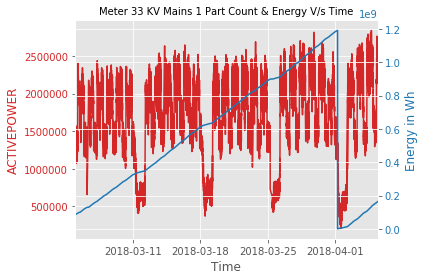

In [13]:
plot_energy_vs_active_power(mains_df_dict_c, meter_ids)

In [14]:
import tensorflow as tf

In [15]:
mains_series = mains_df_dict_c['3']['ACTIVEPOWER']
mains_series = mains_series.resample('H').mean()
mains_series = mains_series.dropna()
mains_df = pd.DataFrame(mains_series)
print (mains_df)

                      ACTIVEPOWER
TIME                             
2018-03-05 00:00:00  1.337356e+06
2018-03-05 01:00:00  1.385717e+06
2018-03-05 02:00:00  1.146767e+06
2018-03-05 03:00:00  1.246333e+06
2018-03-05 04:00:00  1.202950e+06
2018-03-05 05:00:00  1.311550e+06
2018-03-05 06:00:00  1.769417e+06
2018-03-05 07:00:00  2.127617e+06
2018-03-05 08:00:00  1.996732e+06
2018-03-05 11:00:00  1.717070e+06
2018-03-05 12:00:00  1.902183e+06
2018-03-05 13:00:00  1.784550e+06
2018-03-05 14:00:00  1.686317e+06
2018-03-05 15:00:00  1.942550e+06
2018-03-05 16:00:00  1.933333e+06
2018-03-05 17:00:00  2.049167e+06
2018-03-05 18:00:00  2.141450e+06
2018-03-05 19:00:00  1.879367e+06
2018-03-05 20:00:00  2.010300e+06
2018-03-05 21:00:00  1.796100e+06
2018-03-05 22:00:00  1.343333e+06
2018-03-05 23:00:00  1.392317e+06
2018-03-06 00:00:00  1.422133e+06
2018-03-06 01:00:00  1.430117e+06
2018-03-06 02:00:00  1.284650e+06
2018-03-06 03:00:00  1.429683e+06
2018-03-06 04:00:00  1.365383e+06
2018-03-06 05:

In [16]:
print (mains_df.index)
day_list = np.array(mains_df.index.weekday)
print(day_list)

DatetimeIndex(['2018-03-05 00:00:00', '2018-03-05 01:00:00',
               '2018-03-05 02:00:00', '2018-03-05 03:00:00',
               '2018-03-05 04:00:00', '2018-03-05 05:00:00',
               '2018-03-05 06:00:00', '2018-03-05 07:00:00',
               '2018-03-05 08:00:00', '2018-03-05 11:00:00',
               ...
               '2018-04-05 00:00:00', '2018-04-05 01:00:00',
               '2018-04-05 02:00:00', '2018-04-05 03:00:00',
               '2018-04-05 04:00:00', '2018-04-05 05:00:00',
               '2018-04-05 06:00:00', '2018-04-05 07:00:00',
               '2018-04-05 08:00:00', '2018-04-05 09:00:00'],
              dtype='datetime64[ns]', name='TIME', length=742, freq=None)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 

In [17]:
len(day_list)

742

In [18]:
week_switch = [1 if day==5 or day==6 else 0 for day in day_list]
print (week_switch)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 

In [19]:
mains_df.head()

,ACTIVEPOWER
TIME,
2018-03-05 00:00:00,1.337356e+06
2018-03-05 01:00:00,1.385717e+06
2018-03-05 02:00:00,1.146767e+06
2018-03-05 03:00:00,1.246333e+06
2018-03-05 04:00:00,1.202950e+06


In [20]:
min_ahead = 24 * 7
print (min_ahead)
train_set = mains_df.iloc[:-min_ahead]
print (train_set)
test_set = mains_df.iloc[-min_ahead:]

168
                      ACTIVEPOWER
TIME                             
2018-03-05 00:00:00  1.337356e+06
2018-03-05 01:00:00  1.385717e+06
2018-03-05 02:00:00  1.146767e+06
2018-03-05 03:00:00  1.246333e+06
2018-03-05 04:00:00  1.202950e+06
2018-03-05 05:00:00  1.311550e+06
2018-03-05 06:00:00  1.769417e+06
2018-03-05 07:00:00  2.127617e+06
2018-03-05 08:00:00  1.996732e+06
2018-03-05 11:00:00  1.717070e+06
2018-03-05 12:00:00  1.902183e+06
2018-03-05 13:00:00  1.784550e+06
2018-03-05 14:00:00  1.686317e+06
2018-03-05 15:00:00  1.942550e+06
2018-03-05 16:00:00  1.933333e+06
2018-03-05 17:00:00  2.049167e+06
2018-03-05 18:00:00  2.141450e+06
2018-03-05 19:00:00  1.879367e+06
2018-03-05 20:00:00  2.010300e+06
2018-03-05 21:00:00  1.796100e+06
2018-03-05 22:00:00  1.343333e+06
2018-03-05 23:00:00  1.392317e+06
2018-03-06 00:00:00  1.422133e+06
2018-03-06 01:00:00  1.430117e+06
2018-03-06 02:00:00  1.284650e+06
2018-03-06 03:00:00  1.429683e+06
2018-03-06 04:00:00  1.365383e+06
2018-03-06

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
scaler = MinMaxScaler()

In [23]:
train_scaled = scaler.fit_transform(train_set)

In [24]:
day = week_switch[:-min_ahead]
print (day)
train_scaled_final = []
for i in range(len(train_scaled)):
    train_scaled_final.append(list(np.append(train_scaled[i],day[i])))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 

In [25]:
test_scaled = scaler.transform(test_set)
day = week_switch[min_ahead:]
test_scaled_final = []
for i in range(len(test_scaled)):
    test_scaled_final.append(list(np.append(test_scaled[i],day[i])))

In [26]:
def next_batch(training_data,batch_size,steps):
    
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    y_batch = training_data[rand_start:rand_start+steps+1]
    return y_batch[:-1, :].reshape(-1, steps, 2), y_batch[1:, :].reshape(-1, steps, 2) 


In [27]:
x,y = next_batch(np.array(train_scaled_final), 1, 24*7)

In [28]:
# Just one feature, the time series
num_inputs = 2
# Num of steps in each batch
num_time_steps = min_ahead
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 2
num_layers = 1 ## You can also try increasing iterations, but decreasing learning rate
learning_rate = 0.001 
# how many iterations to go through (training steps)
num_train_iterations = 600000
# Size of the batch of data
batch_size = 1
tf.reset_default_graph()

In [29]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs], name = 'Xs')
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs], name = 'ys')

In [30]:
'''cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons),
                                        output_size=num_outputs)] * num_layers)'''


'cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons),\n                                        output_size=num_outputs)] * num_layers)'

In [1]:
# Also play around with GRUCell
with tf.name_scope("LSTM_Layers") as scope: 
    cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons),
    output_size=num_time_steps)
    

NameError: name 'tf' is not defined

In [32]:
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [33]:
outputs = tf.layers.dense(inputs=rnn_outputs, units=num_outputs, activation=None, name='Dense_output')

In [34]:
with tf.name_scope("loss") as scope:
    loss = tf.reduce_mean(tf.square(outputs - y))

with tf.name_scope("train") as scope:
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    '''gvs = optimizer.compute_gradients(loss)
    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]'''
    train = optimizer.minimize(loss)

In [35]:
init = tf.global_variables_initializer()
# Merge all summaries into a single operator

In [36]:
saver = tf.train.Saver()


In [37]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [ ]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    writer = tf.summary.FileWriter("logs/output", sess.graph)
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(np.array(train_scaled_final),batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
#        summary_str = sess.run(merged_summary_op, feed_dict={X: X_batch, y: y_batch})
#        summary_writer.add_summary(summary_str, iteration)
        
        if iteration % 5000 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    writer.close()
    saver.save(sess, "./ex_time_series_model_1.21")

0 	MSE: 0.2426122
5000 	MSE: 0.004373129
10000 	MSE: 0.00091884425
15000 	MSE: 0.0006233013
20000 	MSE: 0.00045100873
25000 	MSE: 0.00051429635
30000 	MSE: 0.0004024587
35000 	MSE: 0.0032255885
40000 	MSE: 0.00035371876
45000 	MSE: 0.00020450476
50000 	MSE: 9.728702e-05
55000 	MSE: 0.00015214887
60000 	MSE: 0.00024501883
65000 	MSE: 0.002515259
70000 	MSE: 0.00012572913
75000 	MSE: 0.00011130509
80000 	MSE: 0.0013723692
85000 	MSE: 9.837243e-05
90000 	MSE: 9.167763e-05
95000 	MSE: 0.00022999685
100000 	MSE: 0.00022808106
105000 	MSE: 8.0686055e-05
110000 	MSE: 0.00034558738
115000 	MSE: 0.00017802604
120000 	MSE: 8.751672e-05
125000 	MSE: 0.00040660487
130000 	MSE: 0.00011142767
135000 	MSE: 0.000111522175
140000 	MSE: 9.614229e-05
145000 	MSE: 0.00017683125
150000 	MSE: 0.0002031474
155000 	MSE: 0.00017365889
160000 	MSE: 0.00013736876
165000 	MSE: 0.00017233756
170000 	MSE: 0.00017594034
175000 	MSE: 0.00010582024
180000 	MSE: 0.00036486288
185000 	MSE: 0.00013327843
190000 	MSE: 7.4

In [ ]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./ex_time_series_model_1.21")

    # Create a numpy array for your genreative seed from the last 12 months of the 
    train_seed = list(train_scaled_final[-num_time_steps:])
    
    ## Now create a for loop that 
    for iteration in range(int(min_ahead)):
        X_batch = np.array(train_seed[-(num_time_steps):]).reshape(1, num_time_steps, 2)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, :])

In [ ]:
results = scaler.inverse_transform(np.array(train_seed[num_time_steps:]).reshape(int(min_ahead),2))

In [ ]:
plt.plot(test_set.index, results[:,0], label='Predicted' )
plt.plot(test_set['ACTIVEPOWER'], label='Actual')
plt.legend()
plt.title('Week Ahead Prediction')
plt.xlabel('Hourly Intervals')
plt.ylabel('Power in W')

In [ ]:
plt.plot(test_set.index[:24], results[:24, 0], label='Predicted' )
plt.plot(test_set[:24], label='Actual')
plt.legend()
plt.title('Day Ahead Prediction')
plt.xlabel('Hourly Intervals')
plt.ylabel('Power in W')

In [ ]:
error = (np.array(test_set['ACTIVEPOWER'][:24]) - results[:24, 0])/ np.array(test_set['ACTIVEPOWER'][:24])/(min_ahead/7)*100
np.sum(error)

In [ ]:
plt.title('Error Plot')
plt.xlabel('Hours ahead in time')
plt.ylabel('% Error')
plt.plot(np.abs(error))

In [ ]:
def import_test_data(database_name, start_date): 
    conn = sqlite3.connect(database_name)
   
        #sql qeury where all the colums are selected and the elements of the table are ordered by time
    df = pd.read_sql("SELECT TIME, ACTIVEPOWER, REALTIME_E FROM RS485SAMPLES WHERE meter_id = 1903 ORDER BY time" , conn)
        
    ndf = pd.DataFrame()
    ndf= df
    ndf = ndf[ndf['TIME'] != ""]    # Drop all data entries without time field
       #Time Index truncated to minutewise accuracies only 
    ndf['TIME'] = pd.to_datetime(ndf['TIME'])
    ndf['TIME'] = ndf['TIME'].values.astype('<M8[m]')
    
    ndf = ndf.set_index('TIME') 
    ndf = ndf[~ndf.index.duplicated(keep='first')]
    ndf = clean_dataframe(ndf, start_date)
    return ndf

def clean_dataframe(info_df, start_date):
    info_df = info_df[start_date: ]
    info_df = info_df[(info_df['ACTIVEPOWER'] < 3000000) & (info_df['ACTIVEPOWER'] > 10000)]
    info_df = info_df[info_df['REALTIME_E'] < 20000000000]
    info_df['del_E'] = info_df['REALTIME_E'] - info_df['REALTIME_E'].shift(1)
    info_df = info_df.iloc[1:]
    info_df = info_df[(info_df['del_E'] > 0) & (info_df['del_E'] < 300000 )]
    return info_dfdrop


In [ ]:
test_df = import_test_data('U:\energy_analytics(EGT)\Jaipur_Data\jaipur_test.db' , '2018-04-10')

In [ ]:
test_df.head()

In [ ]:
plt.plot(test_df['ACTIVEPOWER'])

In [ ]:
mains_series_test = test_df['ACTIVEPOWER']
mains_series_test = mains_series_test.resample('H').mean()
mains_series_test = mains_series_test.dropna()
mains_df_test = pd.DataFrame(mains_series_test)
day_list = np.array(mains_df_test.index.weekday)


In [ ]:
week_switch = [1 if day==5 or day==6 else 0 for day in day_list]
test_scaled = scaler.transform(mains_df_test)
test_scaled_final = []
for i in range(len(test_scaled)):
    test_scaled_final.append(list(np.append(test_scaled[i],week_switch[i])))

In [ ]:

error_list = []
corr_list = []
for day_offset in range(20):
    with tf.Session() as sess:

        # Use your Saver instance to restore your saved rnn time series model
        saver.restore(sess, "./ex_time_series_model_1.20")

        # Create a numpy array for your genreative seed from the last 12 months of the 
        train_seed = list(test_scaled_final[24*day_offset : num_time_steps + 24*day_offset])

        ## Now create a for loop that 
        for iteration in range(int(min_ahead)):
            X_batch = np.array(train_seed[-(num_time_steps):]).reshape(1, num_time_steps, 2)
            y_pred = sess.run(outputs, feed_dict={X: X_batch})
            train_seed.append(y_pred[0, -1, :])

    results = scaler.inverse_transform(np.array(train_seed[num_time_steps:]).reshape(int(min_ahead),2))
    ref_df = mains_df_test[num_time_steps + 24*day_offset : num_time_steps + (day_offset + 1)*24]['ACTIVEPOWER']
    res = results[:24,0]

    error = np.mean(abs((ref_df - results[:24, 0])/ ref_df *100))
    corr = np.corrcoef(ref_df,results[:24, 0])[0,1]
    error_list.append(error)

    corr_list.append(corr)
    fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(15,15))
    ax.set_title('Day Ahead Prediction Error=' + str(error))
    ax.set_ylabel('Active Power in W')
    ax.set_xlabel('Date')
    ax.plot(ref_df.index , results[:24,0], label='Predicted')
    ax.plot(ref_df, label='Actual')
    fig.savefig('jaipur_pred_images/' + str(day_offset) + '.png')   # save the figure to file
    plt.close(fig) 


In [ ]:
error_list.pop(-1)

In [ ]:
corr_list.pop(-1)

In [ ]:
fig, axs1 = plt.subplots()
color = 'tab:red'
axs1.set_ylabel('Error in %', color=color)
axs1.set_xlabel('Day Number')
axs1.set_title('Avg Error=' + str(np.mean(error_list)) + ' Avg Corr=' + str(np.mean(corr_list)))
axs1.plot(error_list, color=color)
axs1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
axs2 = axs1.twinx()
axs2.set_ylabel('Correlation between Actual and predicted value', color=color)
axs2.plot(corr_list, color=color)
axs2.tick_params(axis='y', labelcolor=color)

plt.show()